In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [239]:
def read_data(path):
    df = pd.read_csv(path)
    return df

In [240]:
df_train = read_data('data/train.csv')
df_test = read_data('data/test.csv')
df_submision = read_data('data/sample_submission.csv')

In [241]:
def collumn_split(df):

    # Spliting 'PassengerId' collumn, creating new columns 'Group' and 'InGroup'
    df['Group'] = df['PassengerId'].str.split('_').str[0].astype(int)
    df['GroupSize'] = df.groupby('Group')['Group'].transform('size')
    df['InGroup'] = df['GroupSize'] > 1

    # Splitting 'Name' column, add new collumn 'WithFamily'
    df['Name'] = df['Name'].fillna('unknown unknown')
    df['Surname'] = df['Name'].str.split(' ').str[-1]
    surname_counts = df['Surname'].value_counts()
    if 'unknown' in surname_counts:
        surname_counts = surname_counts.drop('unknown')
    has_family_surname = df['Surname'].apply(lambda x: x != 'unknown' and surname_counts.get(x, 0) > 1)
    df['WithFamily'] = (df['InGroup'] & has_family_surname)

    # Spliting 'Cabin' collumn, creating new columns 'Deck', 'Num' and 'Side'
    df['Cabin'] = df['Cabin'].fillna('unknown/unknown/unknown')
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNumber'] = df['Cabin'].str.split('/').str[1]
    df['Side'] = df['Cabin'].str.split('/').str[2]

    # Add columns "All_Expenses" and 'HasExpenses'
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
    df["All_Expenses"] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
    df['HasExpenses'] = df['All_Expenses'].apply(lambda x: 1 if x>0 else 0)
    
    df['CryoSleep_AnomalousSpending'] = ((df['CryoSleep'] == True) & (df['All_Expenses'] > 0)).astype(int)
    
    # 3. Age insights
    df['IsChild'] = (df['Age'] < 13).astype(int)
    df['IsElderly'] = (df['Age'] > 65).astype(int)

        # Dropping splitted columns
    df = df.drop(columns=['PassengerId', 'Cabin', 'Name'])

    return df

In [242]:
target_column = 'Transported'
categorical_columns = ['HomePlanet', 'Destination', 'Deck', 'Side']
continuous_columns = ['All_Expenses', 'Age', 'FoodCourt', 'ShoppingMall', 'RoomService', 
                      'Spa', 'VRDeck']
boolean_columns = ['CryoSleep', 'VIP', 'WithFamily', 'HasExpenses', 'FoodCourt_bool', 'ShoppingMall_bool', 
                   'RoomService_bool', 'Spa_bool', 'VRDeck_bool', 'CryoSleep_AnomalousSpending', 'IsChild', 'IsElderly']

In [243]:
def drop_unnecessary_columns(df):
    df = df.drop(columns=['Group', 'GroupSize', 'InGroup', 'Surname', 'CabinNumber'])
    return df

In [244]:
def converting_columns_to_correct_type(df):
    
    if target_column in df.columns.tolist():
        df[target_column] = df[target_column].astype(bool)
    for col in df.columns.tolist():
        if col in categorical_columns:
            df[col] = df[col].astype('object')
        elif col in continuous_columns:
            df[col] = df[col].astype('float32')
        elif col in boolean_columns:
            df[col] = df[col].astype(bool)
    
    return df

In [245]:
def simple_missing_data_fill(df):
    
    for col in df.columns.tolist():
        if df[col].isnull().sum() > 0:
            if col in categorical_columns:
                df[col] = df[col].fillna(df[col].mode()[0])
            elif col in continuous_columns:
                df[col] = df[col].fillna(df[col].median())
            elif col in boolean_columns:
                df[col] = df[col].fillna(df[col].mode()[0])
    
    return df

In [246]:
def data_cleaning_and_preparation(df):

    df = collumn_split(df)
    df = drop_unnecessary_columns(df)
    df = simple_missing_data_fill(df)
    df = converting_columns_to_correct_type(df)

    return df

In [247]:
def correlation_matrix(df):
    
    df = df.copy()
    corr = df.select_dtypes(include=['number', 'bool']).corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix")
    plt.show()

In [248]:
def encoding(df_train, df_test):
    
    df_train = pd.get_dummies(df_train, columns=categorical_columns, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=categorical_columns, drop_first=True)
    df_test = df_test.reindex(columns=df_train.columns)
    df_test = df_test.drop(columns=target_column)

    return df_train, df_test

In [249]:
def scaling(df_train, df_test):
    scaler = StandardScaler()
    df_train[continuous_columns] = scaler.fit_transform(df_train[continuous_columns])
    df_test[continuous_columns] = scaler.transform(df_test[continuous_columns])
    
    return df_train, df_test

In [250]:
def last_convert_for_tensorflow(df_train, df_test):
    
    df_train = df_train.astype('float32')
    df_test = df_test.astype('float32')

    return df_train, df_test

In [251]:
def train_test_encoding_scaling_converting_for_tf(df_train, df_test):

    df_train, df_test = encoding(df_train, df_test)
    df_train, df_test = scaling(df_train, df_test)
    df_train, df_test = last_convert_for_tensorflow(df_train, df_test)

    return df_train, df_test

In [252]:
def drop_low_correlation_features(df_train, df_test, threshold=0.1):

    correlations = df_train.corr()[target_column].abs()

    columns_to_keep = correlations[correlations >= threshold].index.tolist()
    
    # Make sure target column is in the columns to keep
    if target_column not in columns_to_keep:
        columns_to_keep.append(target_column)
    
    df_train = df_train[columns_to_keep]
    columns_to_keep.remove(target_column)
    df_test = df_test[columns_to_keep]

    return df_train, df_test

In [253]:
df_train = data_cleaning_and_preparation(df_train)


/var/folders/bj/0v2jl76905s95n66w11nry680000gn/T/ipykernel_77429/3261296494.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/var/folders/bj/0v2jl76905s95n66w11nry680000gn/T/ipykernel_77429/3261296494.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [254]:
df_test = data_cleaning_and_preparation(df_test)

/var/folders/bj/0v2jl76905s95n66w11nry680000gn/T/ipykernel_77429/3261296494.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/var/folders/bj/0v2jl76905s95n66w11nry680000gn/T/ipykernel_77429/3261296494.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [255]:
df_train, df_test = train_test_encoding_scaling_converting_for_tf(df_train, df_test)


In [256]:
df_train, df_test = drop_low_correlation_features(df_train, df_test, 0.05)

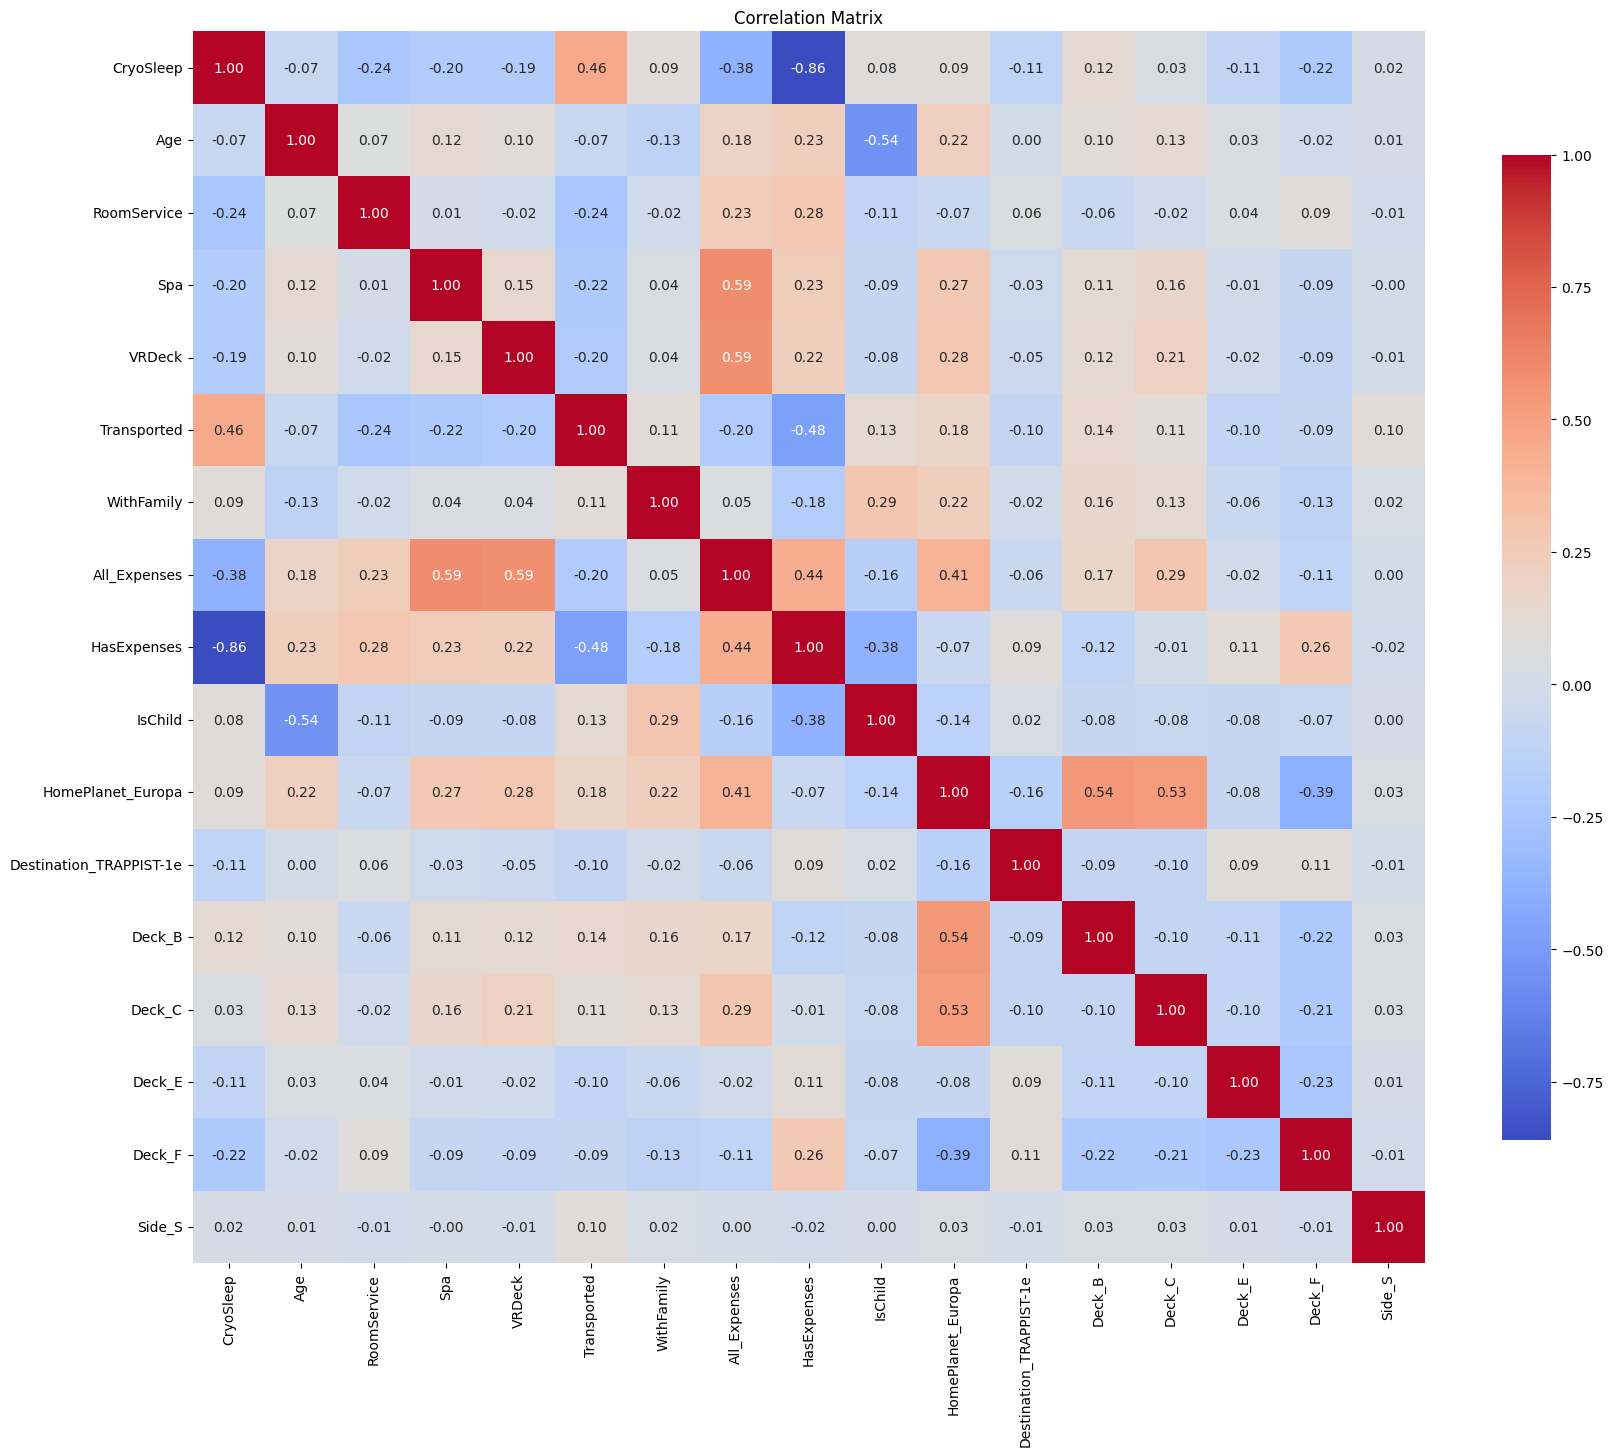

In [257]:
correlation_matrix(df_train)

In [258]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score

def xgb_predictions(df_train, df_test):

    X = df_train.copy()
    y = X['Transported']
    X = X.drop(columns='Transported')
    X_train, X_val, y_train, y_val=train_test_split(X,y, test_size=0.2, random_state=42)

    param_grid = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.5]
    }

    xgb1 = xgb.XGBClassifier(random_state=42)
    random_search = RandomizedSearchCV(xgb1, param_distributions=param_grid, n_iter=20, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1, verbose=1)
    random_search.fit(X_train, y_train)

    print(f"Best parameters: {random_search.best_params_}")
    print(f"Best ROC-AUC: {random_search.best_score_:.4f}")

    focused_param_grid = {
        'n_estimators': [250, 300, 350],
        'max_depth': [5, 6, 7],
        'learning_rate': [0.05, 0.06, 0.07],
        'subsample': [0.9, 1.0],
        'colsample_bytree': [0.9, 1.0],
        'min_child_weight': [1, 2, 3],
        'gamma': [0.30, 0.35, 0.40]
    }

    xgb2 = xgb.XGBClassifier(random_state=42)
    grid_search = GridSearchCV(xgb2, param_grid=focused_param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")

    best_model = random_search.best_estimator_
    best_model.fit(X_train, y_train)

    submision = best_model.predict(df_test)
    df_submision['Transported'] = submision.astype(bool)
    df_submision.to_csv('data/xgb_submisions.csv', index=False)

In [259]:
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore

def simple_nn_predictions(df_train, df_test):

    optimizer = Adam(learning_rate=0.001)

    X = df_train.copy()
    y = X[target_column]
    X = X.drop(columns=target_column)

    def create_improved_model(optimizer=optimizer, activation='relu', neurons=64):
        model = keras.Sequential()
        model.add(layers.InputLayer(input_shape=(X.shape[1],)))
        
        model.add(layers.Dense(neurons))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.Dropout(0.3))
        
        model.add(layers.Dense(neurons // 2))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.Dropout(0.2))
        
        model.add(layers.Dense(neurons // 4))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        
        model.add(layers.Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=optimizer, 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', keras.metrics.AUC()])
        return model

    model = create_improved_model()
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-6),
        keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')
    ]

    history = model.fit(X, y, epochs=150, batch_size=32, validation_split=0.20, verbose=1, callbacks=callbacks)

    best_model = keras.models.load_model('best_model.h5')

    submision = best_model.predict(df_test)
    df_submision['Transported'] = (submision > 0.5).astype(bool)
    df_submision.to_csv('data/nn_submisions.csv', index=False)

In [260]:
from tensorflow import keras
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.optimizers import Adam, AdamW # type: ignore
import optuna

def optuna_predictions(df_train, df_test):

    X = df_train.copy()
    y = X[target_column]
    X = X.drop(columns=target_column)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    def create_model(optimizer='adam', activation='relu', neurons=64, layer_count=1, dropout=0.0, learning_rate=0.001, weight_decay=0.01):

        model = keras.Sequential()
        model.add(layers.InputLayer(shape=(X.shape[1],)))
        for i in range(layer_count):
            model.add(layers.Dense(neurons, activation=activation))
            model.add(layers.Dropout(dropout))
        model.add(layers.Dense(1, activation='sigmoid'))
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer == 'adamw':
            optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return model
    
    # ADDED: Pyramidal model architecture
    def create_pyramidal_model(optimizer='adam', neurons=16, dropout=0.2):

        model = keras.Sequential()
        model.add(layers.InputLayer(shape=(X.shape[1],)))
        model.add(layers.Dense(neurons * 8))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout))
        model.add(layers.Dense(neurons * 4))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout * 0.8))
        model.add(layers.Dense(neurons * 2))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dropout(dropout * 0.6))
        model.add(layers.Dense(neurons))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=0.001)
        elif optimizer == 'adamw':
            optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
    # ADDED: Residual model architecture
    def create_residual_model(optimizer='adam', neurons=16, layer_count=4, dropout=0.2):

        inputs = layers.Input(shape=(X.shape[1],))
        x = layers.LayerNormalization()(inputs)
        for i in range(layer_count):
            residual = x if i > 0 else None
            x = layers.Dense(neurons)(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Dropout(dropout)(x)
            if residual is not None and x.shape[-1] == residual.shape[-1]:
                x = layers.Add()([x, residual])
        outputs = layers.Dense(1, activation='sigmoid')(x)
        model = keras.Model(inputs=inputs, outputs=outputs)
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=0.001)
        elif optimizer == 'adamw':
            optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return model
    
    # ADDED: Ensemble model architecture
    def create_ensemble_model(optimizer='adam', neurons=16, layer_count=4, dropout=0.2):

        inputs = layers.Input(shape=(X.shape[1],))
        x1 = layers.Dense(neurons * 4, activation='relu')(inputs)
        x1 = layers.BatchNormalization()(x1)
        x1 = layers.Dropout(dropout)(x1)
        x1 = layers.Dense(neurons * 2, activation='relu')(x1)
        x2 = inputs
        for i in range(layer_count):
            x2 = layers.Dense(neurons, activation='relu')(x2)
            x2 = layers.BatchNormalization()(x2)
            x2 = layers.Dropout(dropout)(x2)
        merged = layers.Concatenate()([x1, x2])
        merged = layers.Dense(neurons // 2, activation='relu')(merged)
        merged = layers.BatchNormalization()(merged)
        outputs = layers.Dense(1, activation='sigmoid')(merged)
        model = keras.Model(inputs=inputs, outputs=outputs)
        if optimizer == 'adam':
            optimizer = Adam(learning_rate=0.001)
        elif optimizer == 'adamw':
            optimizer = AdamW(learning_rate=0.001, weight_decay=0.01)
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        return model
    
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min'),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-6),
    ]
    
    def objective(trial):

        # ADDED: Model type selection
        model_type = trial.suggest_categorical('model_type', ['standard', 'pyramidal', 'residual', 'ensemble'])
        optimizer = trial.suggest_categorical('optimizer', ['adam', 'adamw'])
        neurons = trial.suggest_int('neurons', 8, 96, step=8)
        batch_size = trial.suggest_categorical('batch_size', [32, 40, 48, 56, 64])
        layer_count = trial.suggest_int('layer_count', 1, 6, step=1)
        dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.025)
        learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.02, log=True)
        weight_decay = trial.suggest_float("weight_decay", 0.0001, 0.1, log=True)
        
        # ADDED: Model selection based on model_type
        if model_type == 'standard':
            model = create_model(optimizer=optimizer, neurons=neurons, layer_count=layer_count, dropout=dropout)
        elif model_type == 'pyramidal':
            model = create_pyramidal_model(optimizer=optimizer, neurons=neurons, dropout=dropout)
        elif model_type == 'residual':
            model = create_residual_model(optimizer=optimizer, neurons=neurons, layer_count=layer_count, dropout=dropout)
        else:  # ensemble
            model = create_ensemble_model(optimizer=optimizer, neurons=neurons, layer_count=layer_count, dropout=dropout)
        
        if optimizer == 'adamw':
            model.optimizer.learning_rate = learning_rate
            model.optimizer.weight_decay = weight_decay

        history = model.fit(X_train, y_train, epochs=100, batch_size=batch_size, validation_split=0.20, verbose=1, callbacks=callbacks)
        loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

        return accuracy
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, n_jobs=1)
    print("Best hyperparameters: ", study.best_params)
    print("Best trial: ", study.best_trial)

    best_params = study.best_params
    model_type = best_params['model_type']
    optimizer = best_params['optimizer']
    neurons = best_params['neurons']
    batch_size = best_params['batch_size']
    layer_count = best_params['layer_count']
    dropout = best_params['dropout']
    learning_rate = best_params['learning_rate']

    if model_type == 'standard':
        best_model = create_model(optimizer=optimizer, neurons=neurons, layer_count=layer_count, dropout=dropout)
    elif model_type == 'pyramidal':
        best_model = create_pyramidal_model(optimizer=optimizer, neurons=neurons, dropout=dropout)
    elif model_type == 'residual':
        best_model = create_residual_model(optimizer=optimizer, neurons=neurons, layer_count=layer_count, dropout=dropout)
    else:  # ensemble
        best_model = create_ensemble_model(optimizer=optimizer, neurons=neurons, layer_count=layer_count, dropout=dropout)

    best_model.fit(X, y, epochs=100, batch_size=batch_size, validation_split=0.20, verbose=1, callbacks=callbacks)

    submision = best_model.predict(df_test)

    df_submision['Transported'] = (submision > 0.5).astype(bool)
    df_submision.to_csv('data/optuna_submisions.csv', index=False)
    

In [261]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# plot_history(history)

In [262]:
xgb_predictions(df_train, df_test)
simple_nn_predictions(df_train, df_test)
optuna_predictions(df_train, df_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best ROC-AUC: 0.8925
Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.4, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 350, 'subsample': 0.9}
Best ROC-AUC: 0.8938


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/150
208/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6599 - auc_4: 0.7183 - loss: 0.6099

218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6629 - auc_4: 0.7219 - loss: 0.6072 - val_accuracy: 0.7930 - val_auc_4: 0.8791 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 2/150
215/218 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7779 - auc_4: 0.8501 - loss: 0.4807

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7779 - auc_4: 0.8501 - loss: 0.4807 - val_accuracy: 0.8016 - val_auc_4: 0.8886 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 3/150
208/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7664 - auc_4: 0.8469 - loss: 0.4816

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7668 - auc_4: 0.8473 - loss: 0.4810 - val_accuracy: 0.8039 - val_auc_4: 0.8911 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 4/150
196/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7735 - auc_4: 0.8638 - loss: 0.4568

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7736 - auc_4: 0.8635 - loss: 0.4572 - val_accuracy: 0.8028 - val_auc_4: 0.8924 - val_loss: 0.4136 - learning_rate: 0.0010
Epoch 5/150
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7916 - auc_4: 0.8706 - loss: 0.4474

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7915 - auc_4: 0.8706 - loss: 0.4474 - val_accuracy: 0.8016 - val_auc_4: 0.8930 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 6/150
205/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7882 - auc_4: 0.8740 - loss: 0.4403

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7880 - auc_4: 0.8738 - loss: 0.4407 - val_accuracy: 0.8016 - val_auc_4: 0.8932 - val_loss: 0.4099 - learning_rate: 0.0010
Epoch 7/150
208/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7786 - auc_4: 0.8656 - loss: 0.4511

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7790 - auc_4: 0.8659 - loss: 0.4507 - val_accuracy: 0.7982 - val_auc_4: 0.8934 - val_loss: 0.4093 - learning_rate: 0.0010
Epoch 8/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7906 - auc_4: 0.8724 - loss: 0.4431 - val_accuracy: 0.7999 - val_auc_4: 0.8932 - val_loss: 0.4098 - learning_rate: 0.0010
Epoch 9/150
209/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - auc_4: 0.8759 - loss: 0.4351

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7957 - auc_4: 0.8758 - loss: 0.4353 - val_accuracy: 0.8062 - val_auc_4: 0.8943 - val_loss: 0.4075 - learning_rate: 0.0010
Epoch 10/150
205/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7886 - auc_4: 0.8737 - loss: 0.4353

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7889 - auc_4: 0.8739 - loss: 0.4350 - val_accuracy: 0.8056 - val_auc_4: 0.8939 - val_loss: 0.4047 - learning_rate: 0.0010
Epoch 11/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7933 - auc_4: 0.8785 - loss: 0.4312 - val_accuracy: 0.8051 - val_auc_4: 0.8947 - val_loss: 0.4098 - learning_rate: 0.0010
Epoch 12/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7912 - auc_4: 0.8757 - loss: 0.4371 - val_accuracy: 0.8074 - val_auc_4: 0.8948 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 13/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7926 - auc_4: 0.8768 - loss: 0.4332 - val_accuracy: 0.8010 - val_auc_4: 0.8951 - val_loss: 0.4068 - learning_rate: 0.0010
Epoch 14/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7793 - auc_4: 0.8672 - loss: 0.4498 - val_accuracy: 0.8045 - val_auc_4: 0.8951 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 15/150
199/218 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accurac

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7928 - auc_4: 0.8802 - loss: 0.4324 - val_accuracy: 0.8028 - val_auc_4: 0.8961 - val_loss: 0.4018 - learning_rate: 0.0010
Epoch 16/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7966 - auc_4: 0.8850 - loss: 0.4207 - val_accuracy: 0.8039 - val_auc_4: 0.8956 - val_loss: 0.4055 - learning_rate: 0.0010
Epoch 17/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7986 - auc_4: 0.8834 - loss: 0.4226 - val_accuracy: 0.8033 - val_auc_4: 0.8955 - val_loss: 0.4025 - learning_rate: 0.0010
Epoch 18/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7922 - auc_4: 0.8735 - loss: 0.4399 - val_accuracy: 0.8028 - val_auc_4: 0.8941 - val_loss: 0.4057 - learning_rate: 0.0010
Epoch 19/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8023 - auc_4: 0.8842 - loss: 0.4217 - val_accuracy: 0.8039 - val_auc_4: 0.8955 - val_loss: 0.4061 - learning_rate: 0.0010
Epoch 20/150
213/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accura

218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7939 - auc_4: 0.8764 - loss: 0.4330 - val_accuracy: 0.8091 - val_auc_4: 0.8966 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 21/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7986 - auc_4: 0.8844 - loss: 0.4202 - val_accuracy: 0.8051 - val_auc_4: 0.8966 - val_loss: 0.4002 - learning_rate: 0.0010
Epoch 22/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7879 - auc_4: 0.8727 - loss: 0.4396 - val_accuracy: 0.8016 - val_auc_4: 0.8953 - val_loss: 0.4048 - learning_rate: 0.0010
Epoch 23/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7959 - auc_4: 0.8795 - loss: 0.4276 - val_accuracy: 0.8045 - val_auc_4: 0.8970 - val_loss: 0.4030 - learning_rate: 0.0010
Epoch 24/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8000 - auc_4: 0.8816 - loss: 0.4230 - val_accuracy: 0.8039 - val_auc_4: 0.8958 - val_loss: 0.4003 - learning_rate: 0.0010
Epoch 25/150
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accurac

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-05-04 19:56:19,422] A new study created in memory with name: no-name-07f8f809-b792-4b83-8791-40035e69b10e


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7520 - loss: 0.5189 - val_accuracy: 0.8016 - val_loss: 0.4109 - learning_rate: 0.0116
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7966 - loss: 0.4385 - val_accuracy: 0.8052 - val_loss: 0.4113 - learning_rate: 0.0116
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7909 - loss: 0.4464 - val_accuracy: 0.8088 - val_loss: 0.4191 - learning_rate: 0.0116
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7960 - loss: 0.4430 - val_accuracy: 0.8081 - val_loss: 0.4154 - learning_rate: 0.0116
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7867 - loss: 0.4500 - val_accuracy: 0.8174 - val_loss: 0.4123 - learning_rate: 0.0116
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7805 - loss: 0.4681 - val_accuracy: 0.8081 - val_loss: 0.4113 - learning_rate: 0.0116
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7739 - loss: 0.

[I 2025-05-04 19:57:07,578] Trial 0 finished with value: 0.796434760093689 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 64, 'batch_size': 32, 'layer_count': 2, 'dropout': 0.17500000000000002, 'learning_rate': 0.011581591391895489, 'weight_decay': 0.07867139454898743}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7195 - loss: 0.5355 - val_accuracy: 0.8095 - val_loss: 0.5383 - learning_rate: 4.2285e-04
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7892 - loss: 0.4312 - val_accuracy: 0.8095 - val_loss: 0.4287 - learning_rate: 4.2285e-04
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7892 - loss: 0.4336 - val_accuracy: 0.8052 - val_loss: 0.4043 - learning_rate: 4.2285e-04
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8002 - loss: 0.4207 - val_accuracy: 0.8138 - val_loss: 0.3936 - learning_rate: 4.2285e-04
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7866 - loss: 0.4318 - val_accuracy: 0.8073 - val_loss: 0.3869 - learning_rate: 4.2285e-04
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8069 - loss: 0.4175 - val_accuracy: 0.8131 - val_loss: 0.3909 - learning_rate: 4.2285e-04
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc

[I 2025-05-04 19:57:51,877] Trial 1 finished with value: 0.7872340679168701 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 88, 'batch_size': 32, 'layer_count': 3, 'dropout': 0.05, 'learning_rate': 0.0004228534247186239, 'weight_decay': 0.0027684394356219597}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7219 - loss: 0.5896 - val_accuracy: 0.8016 - val_loss: 0.4353 - learning_rate: 0.0068
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7759 - loss: 0.4636 - val_accuracy: 0.8152 - val_loss: 0.4046 - learning_rate: 0.0068
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4447 - val_accuracy: 0.7973 - val_loss: 0.4246 - learning_rate: 0.0068
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7996 - loss: 0.4409 - val_accuracy: 0.8145 - val_loss: 0.4086 - learning_rate: 0.0068
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8021 - loss: 0.4225 - val_accuracy: 0.8095 - val_loss: 0.4035 - learning_rate: 0.0068
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7895 - loss: 0.4362 - val_accuracy: 0.8152 - val_loss: 0.3983 - learning_rate: 0.0068
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7974 - loss: 0.

[I 2025-05-04 19:58:29,574] Trial 2 finished with value: 0.7924094200134277 and parameters: {'model_type': 'residual', 'optimizer': 'adamw', 'neurons': 72, 'batch_size': 32, 'layer_count': 2, 'dropout': 0.25, 'learning_rate': 0.006791449982752322, 'weight_decay': 0.054256060997337756}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5654 - loss: 0.6718 - val_accuracy: 0.7678 - val_loss: 0.5546 - learning_rate: 5.9791e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6939 - loss: 0.5758 - val_accuracy: 0.7850 - val_loss: 0.4941 - learning_rate: 5.9791e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7374 - loss: 0.5340 - val_accuracy: 0.7894 - val_loss: 0.4720 - learning_rate: 5.9791e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7460 - loss: 0.5209 - val_accuracy: 0.7915 - val_loss: 0.4578 - learning_rate: 5.9791e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7606 - loss: 0.4947 - val_accuracy: 0.7901 - val_loss: 0.4474 - learning_rate: 5.9791e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7525 - loss: 0.4974 - val_accuracy: 0.7930 - val_loss: 0.4403 - learning_rate: 5.9791e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc

[I 2025-05-04 19:59:01,103] Trial 3 finished with value: 0.7947096228599548 and parameters: {'model_type': 'standard', 'optimizer': 'adamw', 'neurons': 16, 'batch_size': 40, 'layer_count': 2, 'dropout': 0.225, 'learning_rate': 0.0005979095996965077, 'weight_decay': 0.00045556284897047716}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5622 - loss: 0.7144 - val_accuracy: 0.6456 - val_loss: 0.6167 - learning_rate: 1.3334e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6097 - loss: 0.6509 - val_accuracy: 0.7103 - val_loss: 0.5714 - learning_rate: 1.3334e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6874 - loss: 0.5937 - val_accuracy: 0.7484 - val_loss: 0.5373 - learning_rate: 1.3334e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7247 - loss: 0.5591 - val_accuracy: 0.7671 - val_loss: 0.5128 - learning_rate: 1.3334e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7303 - loss: 0.5434 - val_accuracy: 0.7807 - val_loss: 0.4937 - learning_rate: 1.3334e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7595 - loss: 0.5152 - val_accuracy: 0.7858 - val_loss: 0.4791 - learning_rate: 1.3334e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc

[I 2025-05-04 19:59:37,872] Trial 4 finished with value: 0.7866590023040771 and parameters: {'model_type': 'residual', 'optimizer': 'adamw', 'neurons': 40, 'batch_size': 40, 'layer_count': 1, 'dropout': 0.0, 'learning_rate': 0.00013334257815248178, 'weight_decay': 0.00019896054262885605}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7550 - loss: 0.5167 - val_accuracy: 0.7894 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7805 - loss: 0.4445 - val_accuracy: 0.7973 - val_loss: 0.4380 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7940 - loss: 0.4400 - val_accuracy: 0.8131 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7807 - loss: 0.4333 - val_accuracy: 0.8073 - val_loss: 0.3945 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8000 - loss: 0.4217 - val_accuracy: 0.8203 - val_loss: 0.3883 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8146 - loss: 0.4165 - val_accuracy: 0.8109 - val_loss: 0.3939 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8051 - loss: 0

[I 2025-05-04 20:00:23,616] Trial 5 finished with value: 0.7924094200134277 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adam', 'neurons': 80, 'batch_size': 40, 'layer_count': 1, 'dropout': 0.225, 'learning_rate': 0.0036999534825841317, 'weight_decay': 0.006511205215150812}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7284 - loss: 0.5442 - val_accuracy: 0.7534 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7804 - loss: 0.4481 - val_accuracy: 0.7304 - val_loss: 0.4915 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7980 - loss: 0.4208 - val_accuracy: 0.7894 - val_loss: 0.4225 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8003 - loss: 0.4190 - val_accuracy: 0.8131 - val_loss: 0.3971 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7902 - loss: 0.4355 - val_accuracy: 0.8188 - val_loss: 0.3948 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8115 - loss: 0.4034 - val_accuracy: 0.8088 - val_loss: 0.3998 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7955 - loss: 0.

[I 2025-05-04 20:00:49,211] Trial 6 finished with value: 0.78435879945755 and parameters: {'model_type': 'ensemble', 'optimizer': 'adam', 'neurons': 72, 'batch_size': 40, 'layer_count': 4, 'dropout': 0.2, 'learning_rate': 0.00010000733975227658, 'weight_decay': 0.0005274557119598818}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6857 - loss: 0.6214 - val_accuracy: 0.7556 - val_loss: 0.5524 - learning_rate: 2.5593e-04
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7638 - loss: 0.4870 - val_accuracy: 0.7390 - val_loss: 0.4956 - learning_rate: 2.5593e-04
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7684 - loss: 0.4601 - val_accuracy: 0.7858 - val_loss: 0.4387 - learning_rate: 2.5593e-04
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7899 - loss: 0.4426 - val_accuracy: 0.7944 - val_loss: 0.4107 - learning_rate: 2.5593e-04
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7883 - loss: 0.4339 - val_accuracy: 0.8088 - val_loss: 0.4012 - learning_rate: 2.5593e-04
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7875 - loss: 0.4254 - val_accuracy: 0.8030 - val_loss: 0.4040 - learning_rate: 2.5593e-04
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - acc

[I 2025-05-04 20:01:17,396] Trial 7 finished with value: 0.7912593483924866 and parameters: {'model_type': 'ensemble', 'optimizer': 'adamw', 'neurons': 96, 'batch_size': 48, 'layer_count': 5, 'dropout': 0.3, 'learning_rate': 0.000255931804722195, 'weight_decay': 0.00033701446926619893}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7377 - loss: 0.5178 - val_accuracy: 0.7944 - val_loss: 0.4329 - learning_rate: 0.0060
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7828 - loss: 0.4390 - val_accuracy: 0.8138 - val_loss: 0.3978 - learning_rate: 0.0060
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7948 - loss: 0.4282 - val_accuracy: 0.8152 - val_loss: 0.3945 - learning_rate: 0.0060
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8007 - loss: 0.4224 - val_accuracy: 0.8188 - val_loss: 0.3972 - learning_rate: 0.0060
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7963 - loss: 0.4240 - val_accuracy: 0.8160 - val_loss: 0.3938 - learning_rate: 0.0060
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7953 - loss: 0.4288 - val_accuracy: 0.8145 - val_loss: 0.3903 - learning_rate: 0.0060
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8001 - loss: 0.4199 - val_acc

[I 2025-05-04 20:01:40,676] Trial 8 finished with value: 0.7929844856262207 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 48, 'batch_size': 64, 'layer_count': 1, 'dropout': 0.25, 'learning_rate': 0.006028781869815645, 'weight_decay': 0.019301029257637898}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6860 - loss: 0.5826 - val_accuracy: 0.7958 - val_loss: 0.4273 - learning_rate: 0.0055
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4518 - val_accuracy: 0.8102 - val_loss: 0.4105 - learning_rate: 0.0055
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.4287 - val_accuracy: 0.8116 - val_loss: 0.4029 - learning_rate: 0.0055
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8046 - loss: 0.4152 - val_accuracy: 0.8131 - val_loss: 0.4000 - learning_rate: 0.0055
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - loss: 0.4430 - val_accuracy: 0.8131 - val_loss: 0.3977 - learning_rate: 0.0055
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.4273 - val_accuracy: 0.8023 - val_loss: 0.4035 - learning_rate: 0.0055
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7896 - loss: 0.4331 - val_acc

[I 2025-05-04 20:01:55,821] Trial 9 finished with value: 0.7918344140052795 and parameters: {'model_type': 'residual', 'optimizer': 'adamw', 'neurons': 32, 'batch_size': 64, 'layer_count': 1, 'dropout': 0.15000000000000002, 'learning_rate': 0.005470913421255401, 'weight_decay': 0.0038212855690281217}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6639 - loss: 0.6173 - val_accuracy: 0.7973 - val_loss: 0.4458 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7773 - loss: 0.4765 - val_accuracy: 0.8030 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7904 - loss: 0.4554 - val_accuracy: 0.8073 - val_loss: 0.4154 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7882 - loss: 0.4395 - val_accuracy: 0.8196 - val_loss: 0.4045 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8057 - loss: 0.4282 - val_accuracy: 0.8167 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.4245 - val_accuracy: 0.8152 - val_loss: 0.3989 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7955 - loss: 0.

[I 2025-05-04 20:02:13,264] Trial 10 finished with value: 0.78435879945755 and parameters: {'model_type': 'standard', 'optimizer': 'adam', 'neurons': 56, 'batch_size': 56, 'layer_count': 6, 'dropout': 0.1, 'learning_rate': 0.018529413307962227, 'weight_decay': 0.09336332776958874}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5729 - loss: 0.6641 - val_accuracy: 0.7714 - val_loss: 0.5343 - learning_rate: 0.0011
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7163 - loss: 0.5616 - val_accuracy: 0.7901 - val_loss: 0.4561 - learning_rate: 0.0011
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7517 - loss: 0.5138 - val_accuracy: 0.7973 - val_loss: 0.4409 - learning_rate: 0.0011
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7555 - loss: 0.4992 - val_accuracy: 0.7951 - val_loss: 0.4301 - learning_rate: 0.0011
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7685 - loss: 0.4795 - val_accuracy: 0.8059 - val_loss: 0.4194 - learning_rate: 0.0011
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - loss: 0.4721 - val_accuracy: 0.8095 - val_loss: 0.4157 - learning_rate: 0.0011
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7794 - loss: 0.

[I 2025-05-04 20:02:43,207] Trial 11 finished with value: 0.7860839366912842 and parameters: {'model_type': 'standard', 'optimizer': 'adamw', 'neurons': 16, 'batch_size': 32, 'layer_count': 3, 'dropout': 0.17500000000000002, 'learning_rate': 0.0010506327679227967, 'weight_decay': 0.0010216010491195867}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5743 - loss: 0.6729 - val_accuracy: 0.7117 - val_loss: 0.6089 - learning_rate: 0.0012
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7168 - loss: 0.6036 - val_accuracy: 0.7577 - val_loss: 0.5186 - learning_rate: 0.0012
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7408 - loss: 0.5363 - val_accuracy: 0.7750 - val_loss: 0.4662 - learning_rate: 0.0012
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7581 - loss: 0.4994 - val_accuracy: 0.7980 - val_loss: 0.4372 - learning_rate: 0.0012
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7721 - loss: 0.4731 - val_accuracy: 0.8081 - val_loss: 0.4192 - learning_rate: 0.0012
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7849 - loss: 0.4552 - val_accuracy: 0.8124 - val_loss: 0.4114 - learning_rate: 0.0012
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7885 - loss: 0.

[I 2025-05-04 20:03:03,329] Trial 12 finished with value: 0.7889591455459595 and parameters: {'model_type': 'standard', 'optimizer': 'adamw', 'neurons': 8, 'batch_size': 48, 'layer_count': 2, 'dropout': 0.1, 'learning_rate': 0.0012080051592944581, 'weight_decay': 0.01899342903933068}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6829 - loss: 0.5888 - val_accuracy: 0.7908 - val_loss: 0.5562 - learning_rate: 5.4178e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7710 - loss: 0.4709 - val_accuracy: 0.7987 - val_loss: 0.4691 - learning_rate: 5.4178e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7749 - loss: 0.4649 - val_accuracy: 0.8095 - val_loss: 0.4210 - learning_rate: 5.4178e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7838 - loss: 0.4508 - val_accuracy: 0.8088 - val_loss: 0.4026 - learning_rate: 5.4178e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7871 - loss: 0.4366 - val_accuracy: 0.8095 - val_loss: 0.3976 - learning_rate: 5.4178e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7987 - loss: 0.4208 - val_accuracy: 0.8081 - val_loss: 0.3927 - learning_rate: 5.4178e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

[I 2025-05-04 20:03:19,817] Trial 13 finished with value: 0.7809085845947266 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 24, 'batch_size': 56, 'layer_count': 2, 'dropout': 0.125, 'learning_rate': 0.0005417794041935809, 'weight_decay': 0.00010208318449942383}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6279 - loss: 0.6435 - val_accuracy: 0.7858 - val_loss: 0.4521 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.5115 - val_accuracy: 0.8088 - val_loss: 0.4252 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7887 - loss: 0.4675 - val_accuracy: 0.8152 - val_loss: 0.4149 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.4686 - val_accuracy: 0.8109 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7917 - loss: 0.4538 - val_accuracy: 0.8066 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795 - loss: 0.4548 - val_accuracy: 0.8095 - val_loss: 0.4013 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7866 - loss: 0.

[I 2025-05-04 20:03:42,728] Trial 14 finished with value: 0.7901092767715454 and parameters: {'model_type': 'standard', 'optimizer': 'adam', 'neurons': 56, 'batch_size': 40, 'layer_count': 4, 'dropout': 0.3, 'learning_rate': 0.019044262056492765, 'weight_decay': 0.0008241113527884932}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6931 - loss: 0.5648 - val_accuracy: 0.8016 - val_loss: 0.4266 - learning_rate: 0.0025
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.4517 - val_accuracy: 0.8124 - val_loss: 0.4051 - learning_rate: 0.0025
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7884 - loss: 0.4406 - val_accuracy: 0.8030 - val_loss: 0.4048 - learning_rate: 0.0025
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7986 - loss: 0.4107 - val_accuracy: 0.8109 - val_loss: 0.4006 - learning_rate: 0.0025
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7946 - loss: 0.4294 - val_accuracy: 0.8109 - val_loss: 0.3917 - learning_rate: 0.0025
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8060 - loss: 0.4188 - val_accuracy: 0.8116 - val_loss: 0.3910 - learning_rate: 0.0025
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8002 - loss: 0.

[I 2025-05-04 20:04:03,928] Trial 15 finished with value: 0.7878090739250183 and parameters: {'model_type': 'standard', 'optimizer': 'adamw', 'neurons': 64, 'batch_size': 32, 'layer_count': 3, 'dropout': 0.2, 'learning_rate': 0.0024703493077009074, 'weight_decay': 0.0017529802862661793}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7038 - loss: 0.5452 - val_accuracy: 0.8052 - val_loss: 0.4755 - learning_rate: 0.0019
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7654 - loss: 0.4690 - val_accuracy: 0.8131 - val_loss: 0.4129 - learning_rate: 0.0019
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7883 - loss: 0.4569 - val_accuracy: 0.8131 - val_loss: 0.3966 - learning_rate: 0.0019
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8017 - loss: 0.4250 - val_accuracy: 0.8030 - val_loss: 0.3993 - learning_rate: 0.0019
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8040 - loss: 0.4199 - val_accuracy: 0.8030 - val_loss: 0.3996 - learning_rate: 0.0019
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7994 - loss: 0.4293 - val_accuracy: 0.8095 - val_loss: 0.3902 - learning_rate: 0.0019
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8106 - loss: 0.

[I 2025-05-04 20:04:41,771] Trial 16 finished with value: 0.7935594916343689 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 40, 'batch_size': 40, 'layer_count': 2, 'dropout': 0.25, 'learning_rate': 0.001929266007896629, 'weight_decay': 0.007400045809993022}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5762 - loss: 0.7079 - val_accuracy: 0.7563 - val_loss: 0.5586 - learning_rate: 7.1359e-04
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7472 - loss: 0.5296 - val_accuracy: 0.7850 - val_loss: 0.4759 - learning_rate: 7.1359e-04
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7586 - loss: 0.5079 - val_accuracy: 0.7915 - val_loss: 0.4445 - learning_rate: 7.1359e-04
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7774 - loss: 0.4691 - val_accuracy: 0.8116 - val_loss: 0.4268 - learning_rate: 7.1359e-04
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7750 - loss: 0.4651 - val_accuracy: 0.8124 - val_loss: 0.4155 - learning_rate: 7.1359e-04
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7822 - loss: 0.4453 - val_accuracy: 0.8088 - val_loss: 0.4077 - learning_rate: 7.1359e-04
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc

[I 2025-05-04 20:05:21,263] Trial 17 finished with value: 0.785508930683136 and parameters: {'model_type': 'ensemble', 'optimizer': 'adamw', 'neurons': 8, 'batch_size': 32, 'layer_count': 2, 'dropout': 0.15000000000000002, 'learning_rate': 0.0007135878591156432, 'weight_decay': 0.02265307611882573}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5703 - loss: 0.6663 - val_accuracy: 0.7642 - val_loss: 0.5239 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7256 - loss: 0.5526 - val_accuracy: 0.7915 - val_loss: 0.4673 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7584 - loss: 0.5099 - val_accuracy: 0.7901 - val_loss: 0.4421 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7642 - loss: 0.4896 - val_accuracy: 0.7930 - val_loss: 0.4271 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7668 - loss: 0.4773 - val_accuracy: 0.8016 - val_loss: 0.4178 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7705 - loss: 0.4609 - val_accuracy: 0.8088 - val_loss: 0.4085 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.

[I 2025-05-04 20:05:45,286] Trial 18 finished with value: 0.7883841395378113 and parameters: {'model_type': 'standard', 'optimizer': 'adam', 'neurons': 24, 'batch_size': 56, 'layer_count': 3, 'dropout': 0.2, 'learning_rate': 0.0002445185562983583, 'weight_decay': 0.0002823856591451783}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7555 - loss: 0.5033 - val_accuracy: 0.7987 - val_loss: 0.4096 - learning_rate: 0.0112
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7774 - loss: 0.4512 - val_accuracy: 0.8131 - val_loss: 0.4056 - learning_rate: 0.0112
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7881 - loss: 0.4349 - val_accuracy: 0.8174 - val_loss: 0.4292 - learning_rate: 0.0112
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7892 - loss: 0.4326 - val_accuracy: 0.8145 - val_loss: 0.4061 - learning_rate: 0.0112
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7976 - loss: 0.4252 - val_accuracy: 0.8239 - val_loss: 0.3903 - learning_rate: 0.0112
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7975 - loss: 0.4225 - val_accuracy: 0.8203 - val_loss: 0.3879 - learning_rate: 0.0112
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8024 - loss: 0.

[I 2025-05-04 20:06:13,889] Trial 19 finished with value: 0.7860839366912842 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 64, 'batch_size': 48, 'layer_count': 4, 'dropout': 0.07500000000000001, 'learning_rate': 0.011225472579042701, 'weight_decay': 0.0001141926140604514}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6301 - loss: 0.6341 - val_accuracy: 0.8023 - val_loss: 0.4382 - learning_rate: 0.0027
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7877 - loss: 0.4754 - val_accuracy: 0.8045 - val_loss: 0.4330 - learning_rate: 0.0027
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7845 - loss: 0.4611 - val_accuracy: 0.8152 - val_loss: 0.4095 - learning_rate: 0.0027
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7958 - loss: 0.4400 - val_accuracy: 0.8102 - val_loss: 0.4021 - learning_rate: 0.0027
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7905 - loss: 0.4393 - val_accuracy: 0.8160 - val_loss: 0.4076 - learning_rate: 0.0027
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7912 - loss: 0.4418 - val_accuracy: 0.8196 - val_loss: 0.3917 - learning_rate: 0.0027
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7969 - loss: 0.4304 - val_acc

[I 2025-05-04 20:06:35,703] Trial 20 finished with value: 0.7837837934494019 and parameters: {'model_type': 'standard', 'optimizer': 'adamw', 'neurons': 48, 'batch_size': 64, 'layer_count': 5, 'dropout': 0.275, 'learning_rate': 0.0026937248272226634, 'weight_decay': 0.042798682128247424}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7065 - loss: 0.5538 - val_accuracy: 0.8045 - val_loss: 0.4576 - learning_rate: 0.0020
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7806 - loss: 0.4489 - val_accuracy: 0.8131 - val_loss: 0.4078 - learning_rate: 0.0020
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7927 - loss: 0.4280 - val_accuracy: 0.8174 - val_loss: 0.4045 - learning_rate: 0.0020
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7855 - loss: 0.4408 - val_accuracy: 0.8210 - val_loss: 0.3892 - learning_rate: 0.0020
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7863 - loss: 0.4399 - val_accuracy: 0.8145 - val_loss: 0.3885 - learning_rate: 0.0020
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7920 - loss: 0.4306 - val_accuracy: 0.8116 - val_loss: 0.3946 - learning_rate: 0.0020
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7931 - loss: 0.

[I 2025-05-04 20:07:00,334] Trial 21 finished with value: 0.7929844856262207 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 40, 'batch_size': 40, 'layer_count': 2, 'dropout': 0.25, 'learning_rate': 0.0020390755569737284, 'weight_decay': 0.009035903141746177}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7274 - loss: 0.5542 - val_accuracy: 0.8037 - val_loss: 0.4466 - learning_rate: 0.0015
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7691 - loss: 0.4607 - val_accuracy: 0.8088 - val_loss: 0.4093 - learning_rate: 0.0015
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7926 - loss: 0.4317 - val_accuracy: 0.8138 - val_loss: 0.3909 - learning_rate: 0.0015
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7923 - loss: 0.4269 - val_accuracy: 0.8188 - val_loss: 0.3883 - learning_rate: 0.0015
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7977 - loss: 0.4279 - val_accuracy: 0.8145 - val_loss: 0.3934 - learning_rate: 0.0015
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7787 - loss: 0.4363 - val_accuracy: 0.8160 - val_loss: 0.3894 - learning_rate: 0.0015
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7881 - loss: 0.

[I 2025-05-04 20:07:28,749] Trial 22 finished with value: 0.7895342111587524 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 32, 'batch_size': 40, 'layer_count': 2, 'dropout': 0.225, 'learning_rate': 0.0014677895941490164, 'weight_decay': 0.007700087956330958}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6623 - loss: 0.6116 - val_accuracy: 0.7786 - val_loss: 0.5175 - learning_rate: 7.9386e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7727 - loss: 0.4736 - val_accuracy: 0.8102 - val_loss: 0.4250 - learning_rate: 7.9386e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7778 - loss: 0.4455 - val_accuracy: 0.8152 - val_loss: 0.4006 - learning_rate: 7.9386e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7777 - loss: 0.4534 - val_accuracy: 0.8124 - val_loss: 0.3962 - learning_rate: 7.9386e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7822 - loss: 0.4421 - val_accuracy: 0.8102 - val_loss: 0.3983 - learning_rate: 7.9386e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7950 - loss: 0.4349 - val_accuracy: 0.8116 - val_loss: 0.3945 - learning_rate: 7.9386e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

[I 2025-05-04 20:08:07,014] Trial 23 finished with value: 0.7935594916343689 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 24, 'batch_size': 40, 'layer_count': 1, 'dropout': 0.17500000000000002, 'learning_rate': 0.0007938625064719437, 'weight_decay': 0.0016895448351568127}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6185 - loss: 0.6810 - val_accuracy: 0.7793 - val_loss: 0.5578 - learning_rate: 3.5386e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.5032 - val_accuracy: 0.7994 - val_loss: 0.4617 - learning_rate: 3.5386e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7782 - loss: 0.4637 - val_accuracy: 0.8116 - val_loss: 0.4205 - learning_rate: 3.5386e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.4535 - val_accuracy: 0.8131 - val_loss: 0.4032 - learning_rate: 3.5386e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7823 - loss: 0.4444 - val_accuracy: 0.8116 - val_loss: 0.3970 - learning_rate: 3.5386e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7870 - loss: 0.4375 - val_accuracy: 0.8073 - val_loss: 0.3961 - learning_rate: 3.5386e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc

[I 2025-05-04 20:08:48,789] Trial 24 finished with value: 0.7860839366912842 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 40, 'batch_size': 40, 'layer_count': 3, 'dropout': 0.275, 'learning_rate': 0.0003538631696557059, 'weight_decay': 0.09919046560502294}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7273 - loss: 0.5357 - val_accuracy: 0.8059 - val_loss: 0.4120 - learning_rate: 0.0099
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7598 - loss: 0.4635 - val_accuracy: 0.8052 - val_loss: 0.4106 - learning_rate: 0.0099
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7996 - loss: 0.4268 - val_accuracy: 0.8152 - val_loss: 0.4016 - learning_rate: 0.0099
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7785 - loss: 0.4502 - val_accuracy: 0.8102 - val_loss: 0.3973 - learning_rate: 0.0099
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7890 - loss: 0.4452 - val_accuracy: 0.8167 - val_loss: 0.3918 - learning_rate: 0.0099
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7959 - loss: 0.4282 - val_accuracy: 0.8124 - val_loss: 0.4002 - learning_rate: 0.0099
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7901 - loss: 0.

[I 2025-05-04 20:09:14,310] Trial 25 finished with value: 0.7878090739250183 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 16, 'batch_size': 32, 'layer_count': 2, 'dropout': 0.225, 'learning_rate': 0.009948908121227583, 'weight_decay': 0.01219322002963528}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6510 - loss: 0.6550 - val_accuracy: 0.7994 - val_loss: 0.4442 - learning_rate: 0.0010
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7851 - loss: 0.4609 - val_accuracy: 0.8145 - val_loss: 0.4163 - learning_rate: 0.0010
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7720 - loss: 0.4612 - val_accuracy: 0.8102 - val_loss: 0.4049 - learning_rate: 0.0010
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7775 - loss: 0.4647 - val_accuracy: 0.8152 - val_loss: 0.4027 - learning_rate: 0.0010
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7923 - loss: 0.4454 - val_accuracy: 0.8196 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7869 - loss: 0.4440 - val_accuracy: 0.8138 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7956 - loss: 0.

[I 2025-05-04 20:09:40,076] Trial 26 finished with value: 0.7918344140052795 and parameters: {'model_type': 'residual', 'optimizer': 'adam', 'neurons': 64, 'batch_size': 40, 'layer_count': 2, 'dropout': 0.17500000000000002, 'learning_rate': 0.0044489876311219236, 'weight_decay': 0.004054290355405314}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7120 - loss: 0.5708 - val_accuracy: 0.7779 - val_loss: 0.4983 - learning_rate: 0.0017
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7797 - loss: 0.4477 - val_accuracy: 0.8023 - val_loss: 0.4333 - learning_rate: 0.0017
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7979 - loss: 0.4212 - val_accuracy: 0.7994 - val_loss: 0.4110 - learning_rate: 0.0017
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7934 - loss: 0.4318 - val_accuracy: 0.8045 - val_loss: 0.3987 - learning_rate: 0.0017
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7897 - loss: 0.4296 - val_accuracy: 0.8124 - val_loss: 0.3886 - learning_rate: 0.0017
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7990 - loss: 0.4160 - val_accuracy: 0.8174 - val_loss: 0.3930 - learning_rate: 0.0017
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7972 - loss: 0.

[I 2025-05-04 20:10:13,339] Trial 27 finished with value: 0.785508930683136 and parameters: {'model_type': 'ensemble', 'optimizer': 'adamw', 'neurons': 48, 'batch_size': 40, 'layer_count': 3, 'dropout': 0.275, 'learning_rate': 0.001656815462194972, 'weight_decay': 0.03368623800303724}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7420 - loss: 0.5164 - val_accuracy: 0.8109 - val_loss: 0.4127 - learning_rate: 0.0105
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7939 - loss: 0.4427 - val_accuracy: 0.8045 - val_loss: 0.4086 - learning_rate: 0.0105
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7746 - loss: 0.4465 - val_accuracy: 0.8138 - val_loss: 0.3998 - learning_rate: 0.0105
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7800 - loss: 0.4421 - val_accuracy: 0.8095 - val_loss: 0.3968 - learning_rate: 0.0105
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7902 - loss: 0.4380 - val_accuracy: 0.8066 - val_loss: 0.4101 - learning_rate: 0.0105
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7964 - loss: 0.4284 - val_accuracy: 0.8124 - val_loss: 0.3929 - learning_rate: 0.0105
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8116 - loss: 0.

[I 2025-05-04 20:10:44,799] Trial 28 finished with value: 0.7906842827796936 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 32, 'batch_size': 32, 'layer_count': 1, 'dropout': 0.225, 'learning_rate': 0.010477642494102992, 'weight_decay': 0.0009148538942289512}. Best is trial 0 with value: 0.796434760093689.


Epoch 1/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7665 - loss: 0.4931 - val_accuracy: 0.7556 - val_loss: 0.5454 - learning_rate: 4.1734e-04
Epoch 2/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7950 - loss: 0.4359 - val_accuracy: 0.7685 - val_loss: 0.4511 - learning_rate: 4.1734e-04
Epoch 3/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7896 - loss: 0.4196 - val_accuracy: 0.8073 - val_loss: 0.4078 - learning_rate: 4.1734e-04
Epoch 4/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7929 - loss: 0.4308 - val_accuracy: 0.8001 - val_loss: 0.4010 - learning_rate: 4.1734e-04
Epoch 5/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7974 - loss: 0.4179 - val_accuracy: 0.8066 - val_loss: 0.3976 - learning_rate: 4.1734e-04
Epoch 6/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8023 - loss: 0.4192 - val_accuracy: 0.8116 - val_loss: 0.3868 - learning_rate: 4.1734e-04
Epoch 7/100
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc

[I 2025-05-04 20:11:14,280] Trial 29 finished with value: 0.785508930683136 and parameters: {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 88, 'batch_size': 32, 'layer_count': 3, 'dropout': 0.025, 'learning_rate': 0.00041734366458452286, 'weight_decay': 0.00237375709923919}. Best is trial 0 with value: 0.796434760093689.


Best hyperparameters:  {'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 64, 'batch_size': 32, 'layer_count': 2, 'dropout': 0.17500000000000002, 'learning_rate': 0.011581591391895489, 'weight_decay': 0.07867139454898743}
Best trial:  FrozenTrial(number=0, state=1, values=[0.796434760093689], datetime_start=datetime.datetime(2025, 5, 4, 19, 56, 19, 440126), datetime_complete=datetime.datetime(2025, 5, 4, 19, 57, 7, 574424), params={'model_type': 'pyramidal', 'optimizer': 'adamw', 'neurons': 64, 'batch_size': 32, 'layer_count': 2, 'dropout': 0.17500000000000002, 'learning_rate': 0.011581591391895489, 'weight_decay': 0.07867139454898743}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_type': CategoricalDistribution(choices=('standard', 'pyramidal', 'residual', 'ensemble')), 'optimizer': CategoricalDistribution(choices=('adam', 'adamw')), 'neurons': IntDistribution(high=96, log=False, low=8, step=8), 'batch_size': CategoricalDistribution(choices=(3